# Training an MLP on Artificial Time Series Data
This notebook demonstrates how to train a Multi-Layer Perceptron (MLP) on synthetic time series data using the ThreeWToolkit.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from ThreeWToolkit.trainer.trainer import ModelTrainer, TrainerConfig
from ThreeWToolkit.models.mlp import MLPConfig
from ThreeWToolkit.core.enums import (
    ModelTypeEnum,
    OptimizersEnum,
    CriterionEnum,
    ActivationFunctionEnum,
)

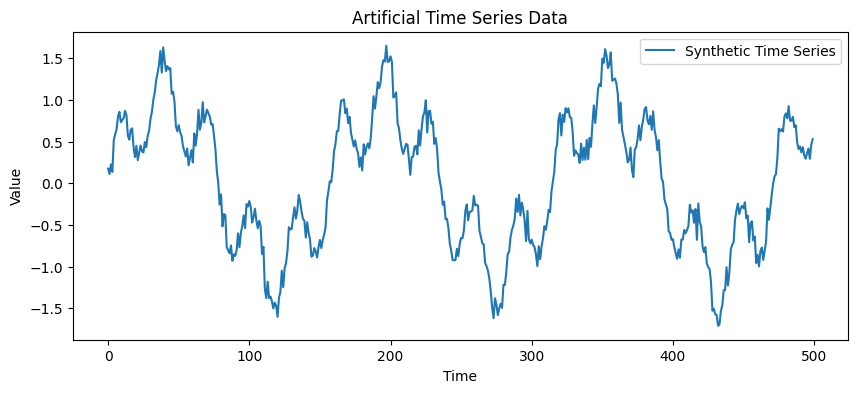

In [2]:
# Generate artificial time series data (sine wave with noise)
np.random.seed(11)
timesteps = 500
x = np.arange(timesteps)
series = np.sin(0.04 * x) + 0.5 * np.sin(0.2 * x) + 0.1 * np.random.randn(timesteps)

plt.figure(figsize=(10, 4))
plt.plot(x, series, label="Synthetic Time Series")
plt.title("Artificial Time Series Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

In [3]:
# Prepare data for MLP: create input-output pairs using sliding window
def create_sliding_windows(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i : i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)


window_size = 20
X, y = create_sliding_windows(series, window_size)
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (480, 20), y shape: (480,)


In [4]:
# Split data into train and validation sets
split_ratio = 0.8
split_idx = int(len(X) * split_ratio)

X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Validation shape: {X_val.shape}, {y_val.shape}")
print(f"type: {type(X_train)}, {type(y_train)}")

Train shape: (384, 20), (384,)
Validation shape: (96, 20), (96,)
type: <class 'numpy.ndarray'>, <class 'numpy.ndarray'>


In [5]:
# Create tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

print(f"Tensor shapes: {X_train_tensor.shape}, {y_train_tensor.shape}")
print(f"Tensor types: {type(X_train_tensor)}, {type(y_train_tensor)}")

Tensor shapes: torch.Size([384, 20]), torch.Size([384, 1])
Tensor types: <class 'torch.Tensor'>, <class 'torch.Tensor'>


In [6]:
mlp_config = MLPConfig(
    input_size=window_size,
    hidden_sizes=(64, 32),
    output_size=1,
    random_seed=11,
    activation_function=ActivationFunctionEnum.RELU,
    regularization=None,
    model_type=ModelTypeEnum.MLP,
)

trainer_config = TrainerConfig(
    optimizer=OptimizersEnum.ADAM,
    criterion=CriterionEnum.MSE,
    batch_size=16,
    epochs=100,
    seed=11,
    config_model=mlp_config,
    learning_rate=0.001,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

trainer = ModelTrainer(trainer_config)

In [7]:
# Print model architecture
print(trainer.model)

MLP(
  (activation_func): ReLU()
  (model): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [8]:
# Train the MLP model using the new ModelTrainer interface
trainer.train(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

Epoch 100/100: 100%|██████████| 100/100 [00:03<00:00, 29.60epoch/s, train_loss=0.0122, val_loss=0.0172]


In [9]:
# Evaluate model performance on validation set using ModelTrainer's test method
from sklearn.metrics import mean_squared_error, r2_score

test_loss, test_metrics = trainer.test(
    X_val_tensor, y_val_tensor, metrics=[mean_squared_error, r2_score]
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Metrics: {test_metrics}")

Test Loss: 0.0172
Test Metrics: {'explained_variance_score': -2.752939032291124e-08}


In [10]:
# Visualize training history
plt.figure(figsize=(10, 5))
plt.plot(trainer.history["train_loss"], label="Train Loss")
plt.plot(trainer.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

AttributeError: 'ModelTrainer' object has no attribute 'history'

<Figure size 1000x500 with 0 Axes>